In [1]:
import os
# Set cuda device to use
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# Prevent memory prealocation
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import jax.numpy as jnp
import jax.random as jr

from itertools import product
from jax import lax
from adsprites import DSprites

In [3]:
batch_size = 4
task = DSprites(batch_size=batch_size, seed=101)
init_obs, init_states = task.init_env()
possible_actions = np.array(list(product([-1, 0, 1], repeat=4))).astype(np.int16)

In [4]:
timesteps = 256

def step_fn(carry, t):
    key, states = carry
    key, _key = jr.split(key)
    
    # random action selection
    actions = jr.choice(_key, possible_actions, shape=(batch_size,))

    # evolve environment
    obs, states = task.step(states, actions)

    return (key, states), (obs, states, actions) 

key = jr.PRNGKey(101)
_, (img_sequence, stat_sequence, action_sequence) = lax.scan(step_fn, (key, init_states), jnp.arange(timesteps))

img_sequence = jnp.concatenate([jnp.expand_dims(init_obs, 0), img_sequence], 0)
img_sequence = img_sequence.transpose(0, 1, 3, 4, 2)

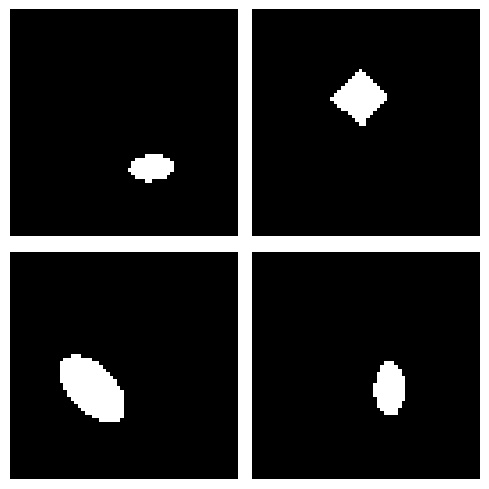

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["animation.html"] = "html5"
import matplotlib.animation
import numpy as np

fig, axes = plt.subplots(2, 2, figsize=(5, 5), sharex=True, sharey=True)

ims = []
for i, ax in enumerate(axes.flatten()):
    ims.append( ax.imshow(img_sequence[0, i], cmap='Greys_r', interpolation='nearest') )
    ax.tick_params(bottom=False, left=False)
    ax.set_yticklabels('')
    ax.set_xticklabels('')

sns.despine(fig, bottom=True, left=True)
fig.tight_layout()

In [6]:
def update_images(t, ims, sequence):
    for i, imshow in enumerate(ims):
        imshow.set_data(sequence[t, i])

In [7]:
animate = lambda t: update_images(t, ims, img_sequence)
ani = matplotlib.animation.FuncAnimation(fig, animate, frames=timesteps)
ani

In [23]:
color_img1 = init_obs[2].transpose(1, 2, 0) * np.array([.9, .5, .3])
color_img2 = init_obs[:-1].squeeze().transpose(1, 2, 0).astype(np.float32)

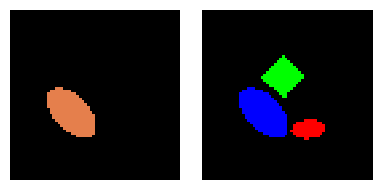

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(4, 2), sharex=True, sharey=True)

axes[0].imshow(color_img1, interpolation='nearest')
axes[1].imshow(color_img2, interpolation='nearest')

for ax in axes:
    ax.tick_params(bottom=False, left=False)
    ax.set_yticklabels('')
    ax.set_xticklabels('')

sns.despine(fig, bottom=True, left=True)
fig.tight_layout()